# Adding Milk

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [26]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [27]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

In [28]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap15.py')

In [29]:
# import code from previous notebooks

from chap15 import change_func
from chap15 import run_simulation
from chap15 import make_system

In the previous chapter we wrote a simulation of a cooling cup of
coffee. 
Given the initial temperature of the coffee, the temperature of the atmosphere, and the rate parameter, `r`, we predicted the temperature of the coffee over time.
Then we used a root finding algorithm to estimate `r` based on data.

If you did the exercises, you simulated the temperature of the milk as it warmed, and estimated its rate parameter as well.

Now let's put it together.
In this chapter we'll write a function that simulates mixing the two liquids, and use it to answer the question we started with: is it better to mix the coffee and milk at the beginning, the end, or somewhere in the middle?

## Mixing Liquids

When we mix two liquids, the temperature of the mixture depends on the
temperatures of the ingredients as well as their volumes, densities, and specific heat capacities (as defined in the previous chapter).
In this section I'll explain how.

Assuming there are no chemical reactions that either produce or consume heat, the total thermal energy of the system is the same before and after mixing; in other words, thermal energy is *conserved*.

If the temperature of the first liquid is $T_1$, the temperature of the second liquid is $T_2$, and the final temperature of the mixture is $T$, the heat transfer into the first liquid is $C_1 (T - T_1)$ and the heat transfer into the second liquid is $C_2 (T - T_2)$, where $C_1$ and $C_2$ are the thermal masses of the liquids.

In order to conserve energy, these heat transfers must add up to 0:

$$C_1 (T - T_1) + C_2 (T - T_2) = 0$$ 

We can solve this equation for T:

$$T = \frac{C_1 T_1 + C_2 T_2}{C_1 + C_2}$$ 

For the coffee cooling problem, we have the volume of each liquid; if we also know the density, $\rho$, and the specific heat capacity, $c_p$, we can compute thermal mass: 

$$C = \rho V c_p$$ 

If the liquids have the same density and heat capacity, they drop out of the equation, and we can write:

$$T = \frac{V_1 T_1 + V_2 T_2}{V_1 + V_2}$$ 

where $V_1$ and $V_2$ are the volumes of the liquids.

As an approximation, I'll assume that milk and coffee have the same
density and specific heat. If you are interested, you can look up these
quantities and see how good this assumption is.

Now let's simulate the mixing process.
The following function takes two `System` objects, representing the
coffee and milk, and creates a new `System` to represent the mixture:

In [30]:
def mix(system1, system2):
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.T_final, system2.T_final
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       volume=V_mix,
                       r=system1.r,
                       t_end=30)

The first two lines extract volume and temperature from the `System` objects. The next two lines compute the volume and temperature of the mixture. Finally, `mix` makes a new `System` object and returns it.

This function uses the value of `r` from `system1` as the value of `r`
for the mixture. If `system1` represents the coffee, and we are adding
the milk to the coffee, this is probably a reasonable choice. On the
other hand, when we increase the amount of liquid in the coffee cup,
that might change `r`. So this is an assumption we might want to
revisit.

Now we have everything we need to solve the problem.

## Mix First or Last?

First I'll create objects to represent the coffee and milk.
For `r_coffee`, I'll use the value we computed in the previous chapter.

In [31]:
r_coffee = 0.0115
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)

For `r_milk`, I'll use the value I estimated in the exercise from the previous chapter.

In [32]:
r_milk = 0.133
milk = make_system(T_init=5, volume=50, r=r_milk, t_end=15)

Now we can mix them and simulate 30 minutes:

In [33]:
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)

mix_first.T_final

61.48016207445017

The final temperature is 61.5 °C which is still warm enough to be
enjoyable. Would we do any better if we added the milk last?

I'll simulate the coffee and milk separately, and then mix them:

In [34]:
run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
mix_last.T_final

62.91117032872072

After mixing, the temperature is 62.9 °C, so it looks like adding the
milk at the end is better. 
But is that the best we can do?

## Optimal Timing

Adding the milk after 30 minutes is better than adding it immediately, but maybe there's something in between that's even better. To find out, I'll use the following function, which takes the time to add the milk, `t_add`, as a parameter:

In [35]:
def run_and_mix(t_add, t_total):
    coffee.t_end = t_add
    coffee_results = run_simulation(coffee, change_func)
    
    milk.t_end = t_add
    milk_results = run_simulation(milk, change_func)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_simulation(mixture, change_func)

    return mixture.T_final

`run_and_mix` simulates both systems for the given time, `t_add`.
Then it mixes them and simulates the mixture for the remaining time, `t_total - t_add`.

When `t_add` is `0`, we add the milk immediately; when `t_add` is `30`, we add it at the end. Now we can sweep the range of values in between:

In [36]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the results look like:

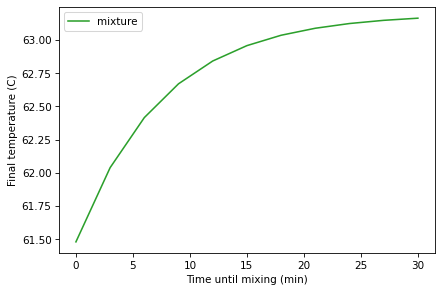

In [37]:
sweep.plot(label='mixture', color='C2')

decorate(xlabel='Time until mixing (min)',
         ylabel='Final temperature (C)')

Note that this is a parameter sweep, not a time series.

The final temperature is maximized when `t_add=30`, so adding the milk
at the end is optimal.

## Analytic Solution

Simulating Newton's law of cooling isn't really necessary because we can solve the differential equation analytically. If

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

the general solution is

$$T{\left (t \right )} = C \exp(-r t) + T_{env}$$ 

and the particular solution where $T(0) = T_{init}$ is

$$T_{env} + \left(- T_{env} + T_{init}\right) \exp(-r t)$$ 

If you would like to see this solution done by hand, you can watch this video: <http://modsimpy.com/khan3>.

Now we can use the observed data to estimate the parameter $r$. If we
observe the that the temperature at $t_{end}$ is $T_{final}$, we can plug these values into the particular solution and solve for $r$. The result is:

$$r = \frac{1}{t_{end}} \log{\left (\frac{T_{init} - T_{env}}{T_{final} - T_{env}} \right )}$$

The following function takes a `System` object and computes `r`:

In [38]:
from numpy import log

def compute_r(system):
    t_end = system.t_end
    T_init = system.T_init
    T_final = system.T_final
    T_env = system.T_env
    
    r = log((T_init - T_env) / (T_final - T_env)) / t_end
    return r

We can use this function to compute `r` for the coffee, given the parameters of the problem.

In [39]:
coffee2 = make_system(T_init=90, volume=300, r=0, t_end=30)
coffee2.T_final = 70
r_coffee2 = compute_r(coffee2)
r_coffee2

0.01161022314227386

This value is close to the value of `r` we computed in the previous chapter, `0.115`, but not exactly the same.
That's because the simulations use discrete time steps, and the analysis uses continuous time.

Nevertheless, the results of the analysis are consistent with the simulation.
To check, we'll use the following function, which takes a `System` object and uses the analytic result to compute a time series:

In [40]:
from numpy import exp

def run_analysis(system):
    T_env, T_init, r = system.T_env, system.T_init, system.r
    
    t_array = linrange(system.t_0, system.t_end, system.dt)    
    T_array = T_env + (T_init - T_env) * exp(-r * t_array)
    
    system.T_final = T_array[-1]
    return make_series(t_array, T_array)

The first line unpacks the system variables.
The next two lines compute `t_array`, which is a NumPy array of time stamps, and `T_array`, which is an array of the corresponding temperatures.
The last two lines store the final temperature in the `System` object and use `make_series` to return the results in a Pandas `Series`.

We can run it like this:

In [41]:
coffee2.r = r_coffee2
results2 = run_analysis(coffee2)
coffee2.T_final

70.0

The final temperature is 70 °C, as it should be. In fact, the results
are identical to what we got by simulation, with a small difference due to rounding.

In [42]:
coffee.r = 0.011543
results = run_simulation(coffee, change_func)

In [43]:
from numpy import allclose

allclose(results, results2)

True

Since we can solve this problem analytically, you might wonder why we bothered writing a simulation. 
One reason is validation: since we solved the same problem two ways, we can be more confident that the answer is correct. 
The other reason is flexibility: now that we have a working simulation, it would be easy to add more features. For example, the temperature of the environment might change over time, or we could simulate the coffee and container as two objects. 
If the coffee and milk are next to each other, we could include the heat flow between them. A model with these features would be difficult or impossible to solve analytically. 

## Summary

In this chapter we finished the coffee cooling problem from the previous chapter, and found that it is better to add the milk at the end, at least for the version of the problem I posed.

As an exercise you will have a chance to explore a variation of the problem where the answer might be different.

In the next chapter we'll move on to a new example, a model of how glucose and insulin interact to control blood sugar.

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1

Use `compute_r` to compute `r_milk` according to the analytic solution.  Run the analysis with this value of `r_milk` and confirm that the results are consistent with the simulation.

In [44]:
#To compute a second iteration of r_milk according to the analytic solution we will need to start by setting a new milk variable
# Have to think in farenheit for this :)
#setting the initial temperature of the milk to 5 degrees fahrenheit because its typically stored in the fridge at that temp
# according to an online coffee expert the 
milk_v2 = make_system(T_init=5, volume=50, r=0, t_end=15.66)

#setting the final temperature of the milk to 65 degrees farenheit
milk_v2.T_final = 18.3333

r_milk_v2 = compute_r(milk_v2)
r_milk_v2

0.09795154974828778

In [45]:
milk_v2 = make_system(T_init=5, volume=50, r=r_milk_v2, t_end=15.66)
results_milk_v2 = run_analysis(milk_v2)
milk_v2.T_final

18.3333

In [50]:
milk = make_system(T_init=5, volume=50, r=0.10, t_end=15.66)
results_milk = run_simulation(milk, change_func)
milk.T_final
results_milk_v2

index
0.00000      5.000000
0.97875      6.554105
1.95750      7.966137
2.93625      9.249084
3.91500     10.414747
4.89375     11.473847
5.87250     12.436126
6.85125     13.310436
7.83000     14.104818
8.80875     14.826579
9.78750     15.482359
10.76625    16.078188
11.74500    16.619548
12.72375    17.111418
13.70250    17.558322
14.68125    17.964371
15.66000    18.333300
Name: values, dtype: float64

In [47]:
#checking if the results are close, they are but not exactly the same due to the fact that the r value is not exactly the same and does
#make a difference in the final temperature
allclose(results_milk, results_milk_v2)

False

### Exercise 2

Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [23]:
# Solution goes here